Filtering DataFrame...


/tmp/ipykernel_5102/2852952634.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_hashtags = top_hashtags.append({'hashtag': manual_hashtag, 'weight': manual_weight}, ignore_index=True)
/tmp/ipykernel_5102/2852952634.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_hashtags = top_hashtags.append({'hashtag': manual_hashtag, 'weight': manual_weight}, ignore_index=True)


Number of unique users: 458964
Number of unique hashtags: 100000
Creating graph...
Added vertices...
Computing edges...
Missing hashtags: set()
Adding edges...
Number of vertices:  558964
Number of edges:  18125602
Finding communities...
Number of communities:  7


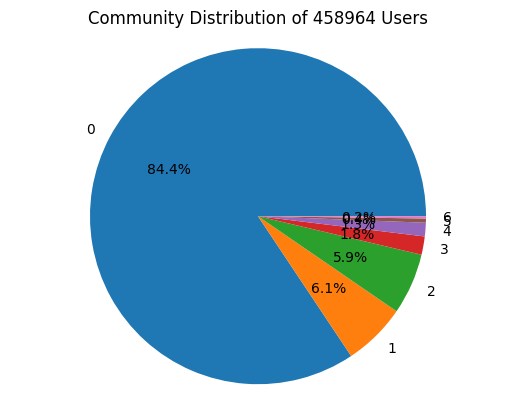

In [7]:
import os, yerbamate
import pandas as pd
import igraph as ig
import leidenalg as la
import matplotlib.pyplot as plt

env = yerbamate.Environment()

path = os.path.join(env["plots"], "analysis", "user_hashtag_all.parquet")
df = pd.read_parquet(path)

df_after = pd.read_parquet(
    os.path.join(env["plots"], "analysis", "user_hashtag_after.parquet")
)

hashtags_path = os.path.join(env["save"], "exclusive_hashtag_propaganda.csv")
weighted_hashtags = pd.read_csv(hashtags_path)

print("Filtering DataFrame...")

# Count occurrences of each hashtag
hashtag_counts = df.groupby("hashtag").size().reset_index().rename(columns={0: 'counts'})


# Get the top 100000 hashtags by counts
top_hashtags = hashtag_counts.nlargest(100000, 'counts')

# Assign weights based on the 'exclusive_propaganda' column
weighted_hashtags["weight"] = weighted_hashtags["exclusive_propaganda"].apply(lambda x: 1 if x == 0 else 200000)

# Keep only 'hashtag' and 'weight' columns
weighted_hashtags = weighted_hashtags[["hashtag", "weight"]]

# Merge 'top_hashtags' with 'weighted_hashtags' and fill NaN values with 1
top_hashtags = top_hashtags.merge(weighted_hashtags, on="hashtag", how="left")
top_hashtags['weight'].fillna(1, inplace=True)

manual_hashtag= 'KurdistanRepublic'
manual_weight = 2000000

top_hashtags = top_hashtags.append({'hashtag': manual_hashtag, 'weight': manual_weight}, ignore_index=True)

manual_hashtag = 'جمهوری_کوردستان'
manual_weight = 2000000

top_hashtags = top_hashtags.append({'hashtag': manual_hashtag, 'weight': manual_weight}, ignore_index=True)

# replace zero with 1
# top_hashtags["weight"] = top_hashtags["weight"] * 2 + 1

# times 2 if not 1 or 0
# top_hashtags["weight"] = top_hashtags["weight"].apply(lambda x: x * 3 + 5 if x >= 1 else x + 1)

# top_hashtags["weight"] = top_hashtags["weight"] * 2 + 1

# drop weight 0 hashtags
# top_hashtags = top_hashtags[top_hashtags["weight"] > 0]


# create a set of the top hashtags for faster lookup
top_hashtags_set = set(top_hashtags["hashtag"])

# filter the original DataFrame
df_filtered = df[df["hashtag"].isin(top_hashtags_set)]

df_unfiltered = df[df["userId"].isin(df_filtered["userId"])]
df = df_filtered

# prrint number of unique users and hashtags
print(f"Number of unique users: {len(df['userId'].unique())}")
print(f"Number of unique hashtags: {len(df['hashtag'].unique())}")

print("Creating graph...")
# initialize a new graph
g = ig.Graph(directed=False)
# g.add_vertex(n=len(df["userId"].unique()), type="user")
# g.add_vertex(n=len(df["hashtag"].unique()), type="hashtag")
user_size = len(df["userId"].unique())


g.add_vertices(n=len(df["userId"].unique()) + len(df["hashtag"].unique()))

# set name of hashtags to be the hashtag itself
g.vs[user_size:]["name"] = df["hashtag"].unique()

# Add types for vertices
g.vs["type"] = [True if i < user_size else False for i in range(g.vcount())]


print("Added vertices...")
# map users and hashtags to unique integers
user_mapping = {user: i for i, user in enumerate(df["userId"].unique())}
hashtag_mapping = {
    hashtag: i + len(user_mapping) for i, hashtag in enumerate(df["hashtag"].unique())
}

print("Computing edges...")


df["user_id"] = df["userId"].map(user_mapping)
df["hashtag_id"] = df["hashtag"].map(hashtag_mapping)
top_hashtags["hashtag_id"] = top_hashtags["hashtag"].map(hashtag_mapping)

df_unfiltered["user_id"] = df_unfiltered["userId"].map(user_mapping)
df_unfiltered["hashtag_id"] = df_unfiltered["hashtag"].map(hashtag_mapping)

# df['weight'] = df['hashtag_id'].map(lambda x: top_hashtags[top_hashtags['hashtag_id'] == x]['weight'].values[0])

# create the list of edges
edges = list(zip(df["user_id"], df["hashtag_id"]))

# weight is the weight in top_hashtags dataframe, where as if the edge ends with hashtag_id, the weight is the top_hashtags['hashtag'] weight
# weights = [top_hashtags[top_hashtags['hashtag_id'] == x[1]]['weight'].values[0] for x in edges]
# edges.map(lambda x: top_hashtags[top_hashtags['hashtag_id'] == x[1]]['weight'])
hashtag_id_to_weight = top_hashtags.set_index("hashtag_id")["weight"].to_dict()

missing_hashtags = set(x[1] for x in edges) - set(hashtag_id_to_weight.keys())
print(f"Missing hashtags: {missing_hashtags}")


weights = [hashtag_id_to_weight[x[1]] for x in edges]

print("Adding edges...")

g.add_edges(edges)

# weights = df["count"].values

# normalize the weights
# weights = weights / weights.max()

g.es["weight"] = weights


# # add the edges with weights
# g.es["weight"] = weightsu

# # add the edges with weights
# g.es['weight'] = weights
print("Number of vertices: ", len(g.vs))
print("Number of edges: ", len(g.es))

print("Finding communities...")


# get the partition using the Leiden algorithm
import leidenalg as la

partition = la.find_partition(
    g, la.ModularityVertexPartition, weights=weights, n_iterations=10
)  # g.es["weight"])

print("Number of communities: ", len(partition))

# add the partition to the graph
g.vs["partition"] = partition.membership

df["community"] = df["user_id"].map(lambda x: g.vs[x]["partition"])


# df after has differet size, we only want to keep people that are in the graph
df_after = df_after[df_after["userId"].isin(df["userId"].unique())]

df_after["user_id"] = df_after["userId"].map(user_mapping)
# df_after["hashtag_id"] = df_after["hashtag"].map(hashtag_mapping)

df_after["community"] = df_after["user_id"].map(lambda x: g.vs[x]["partition"])
df_unfiltered["community"] = df_unfiltered["user_id"].map(
    lambda x: g.vs[x]["partition"]
)

# Get the community sizes
community_sizes = partition.sizes()

# Plot the pie chart
plt.pie(community_sizes, labels=range(len(community_sizes)), autopct="%1.1f%%")
plt.title(f"Community Distribution of {len(df['userId'].unique())} Users")
plt.axis("equal")

# Show the chart
plt.show()

In [33]:
# loading graph

import igraph as ig
import os, yerbamate, pandas as pd

env = yerbamate.Environment()
graph_save_path = os.path.join(env['save'], 'graph', 'hashtag_communities', 'hashtag_communities_bipart_0finetune.graphml')


path = os.path.join(env["plots"], "analysis", "user_hashtag_before.parquet")

df = pd.read_parquet(path)


df_after = pd.read_parquet(os.path.join(env['plots'], 'analysis', 'user_hashtag_after.parquet'))


hashtags_path = os.path.join(env['save'], 'hashtags', 'top_hashtag_before.csv')

print("Filtering DataFrame...")

# hashtag_counts = df.groupby("hashtag").size().reset_index(name="counts")
top_hashtags = pd.read_csv(hashtags_path)


# replace zero with 1
# top_hashtags["weight"] = top_hashtags["weight"] * 2 + 1

# times 2 if not 1 or 0
top_hashtags["weight"] = top_hashtags["weight"].apply(lambda x: x * 5 + 10 if x >= 1 else x + 1)
# create a set of the top hashtags for faster lookup
top_hashtags_set = set(top_hashtags["hashtag"])

# filter the original DataFrame
df_filtered = df[df["hashtag"].isin(top_hashtags_set)]

df_unfiltered = df[df['userId'].isin(df_filtered['userId'])]

df = df_filtered


# prrint number of unique users and hashtags
print(f"Number of unique users: {len(df['userId'].unique())}")
print(f"Number of unique hashtags: {len(df['hashtag'].unique())}")

print("Loading graph...")

g = ig.Graph.Read_GraphML(graph_save_path)

# map users and hashtags to unique integers
user_mapping = {user: i for i, user in enumerate(df["userId"].unique())}
hashtag_mapping = {
    hashtag: i + len(user_mapping) for i, hashtag in enumerate(df["hashtag"].unique())
}

  

df["user_id"] = df["userId"].map(user_mapping)
df["hashtag_id"] = df["hashtag"].map(hashtag_mapping)

df['community'] = df['user_id'].map( lambda x: g.vs[x]['partition'])


# df after has differet size, we only want to keep people that are in the graph
df_after = df_after[df_after['userId'].isin(df['userId'].unique())]

df_after["user_id"] = df_after["userId"].map(user_mapping)
# df_after["hashtag_id"] = df_after["hashtag"].map(hashtag_mapping)

df_after['community'] = df_after['user_id'].map( lambda x: g.vs[x]['partition'])
df_unfiltered['user_id'] = df_unfiltered['userId'].map(user_mapping)
df_unfiltered['community'] = df_unfiltered['user_id'].map( lambda x: g.vs[x]['partition'])
df_unfiltered['hashtag_id'] = df_unfiltered['hashtag'].map(hashtag_mapping)


Filtering DataFrame...
Number of unique users: 109227
Number of unique hashtags: 1503
Loading graph...


Community distribution statistics: 
[64835, 11951, 9366, 7972, 7521, 7199, 1626, 126, 117, 5, 4, 2, 2, 2, 2]


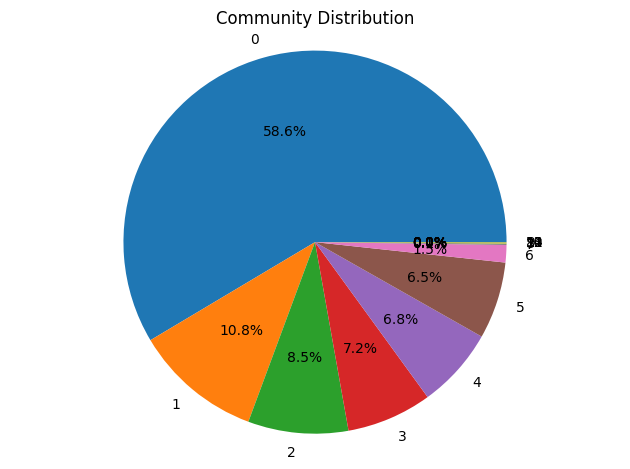

In [77]:
# Plot the pie chart
plt.pie(community_sizes, labels=range(len(community_sizes)), autopct='%1.1f%%')
plt.title('Community Distribution')
plt.axis('equal')

save_path_pie = os.path.join(env["plots"], "analysis", "community1_finetune", "community_pie.png")

if not os.path.exists(os.path.dirname(save_path_pie)):
    os.makedirs(os.path.dirname(save_path_pie))

# tight_layout() adjusts the subplot params so that the subplot(s) fits in to the figure area.
plt.tight_layout()

# remove the extra white space on the right side of the plot
# plt.subplots_adjust(right=1)
# plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
plt.savefig(save_path_pie)

# print distribution statistics

print("Community distribution statistics: ")
print(community_sizes)

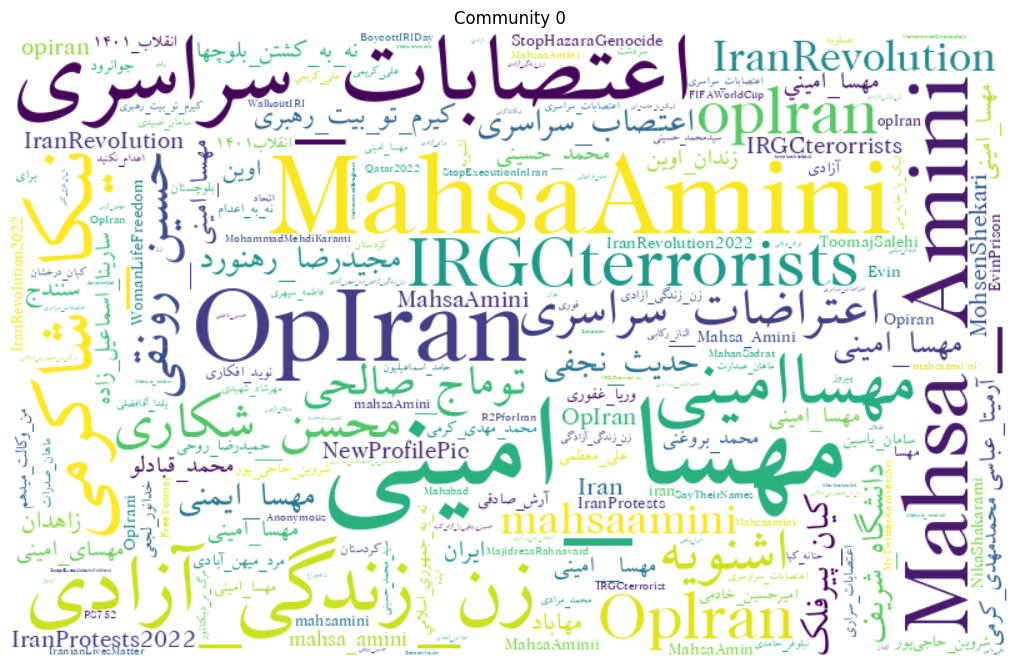

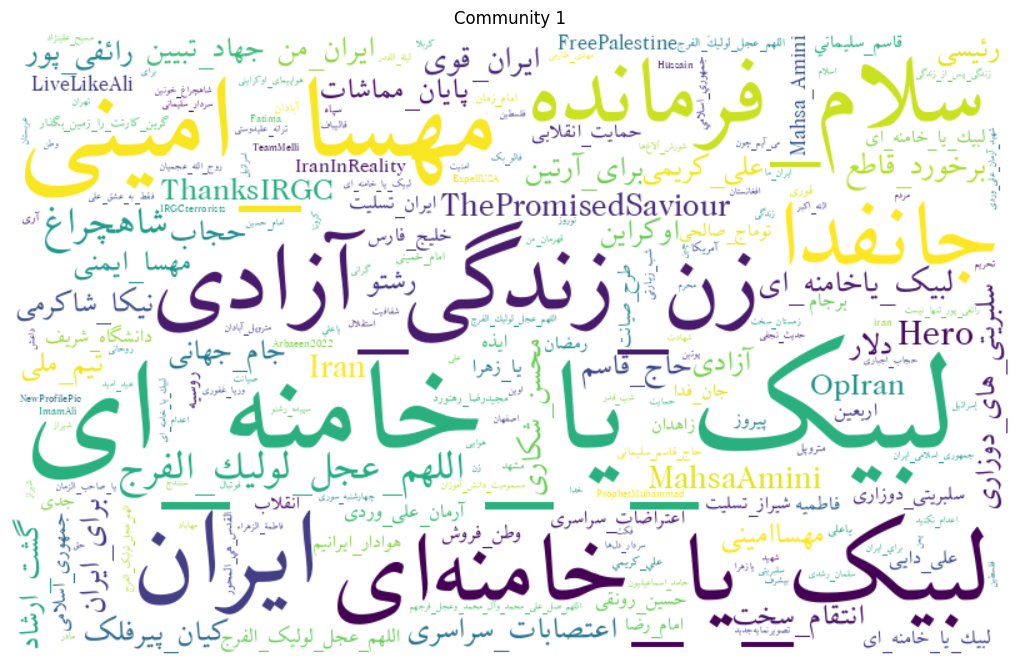

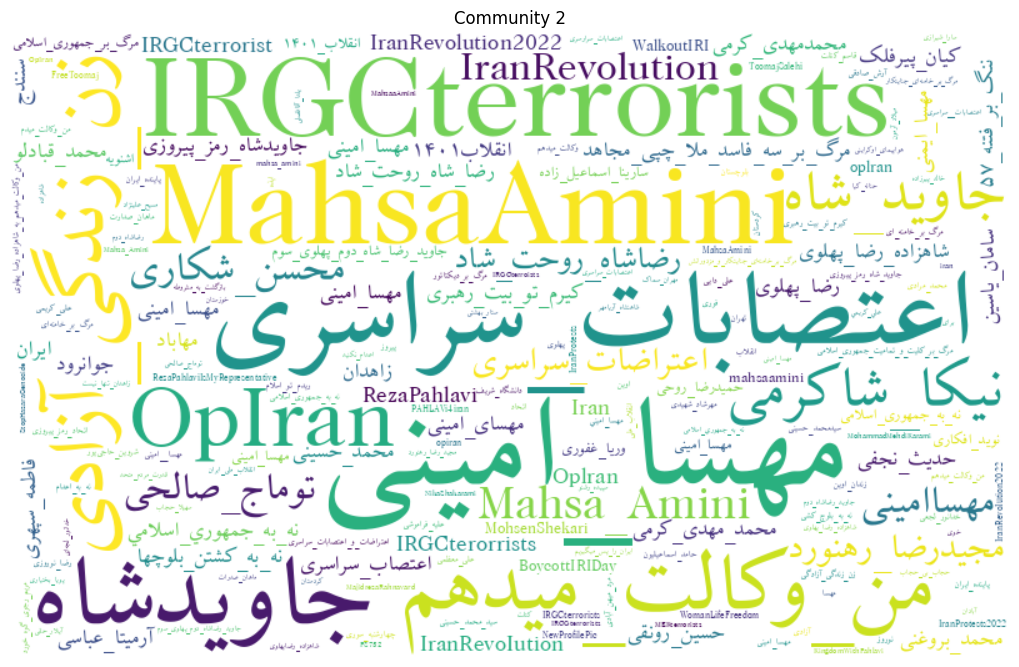

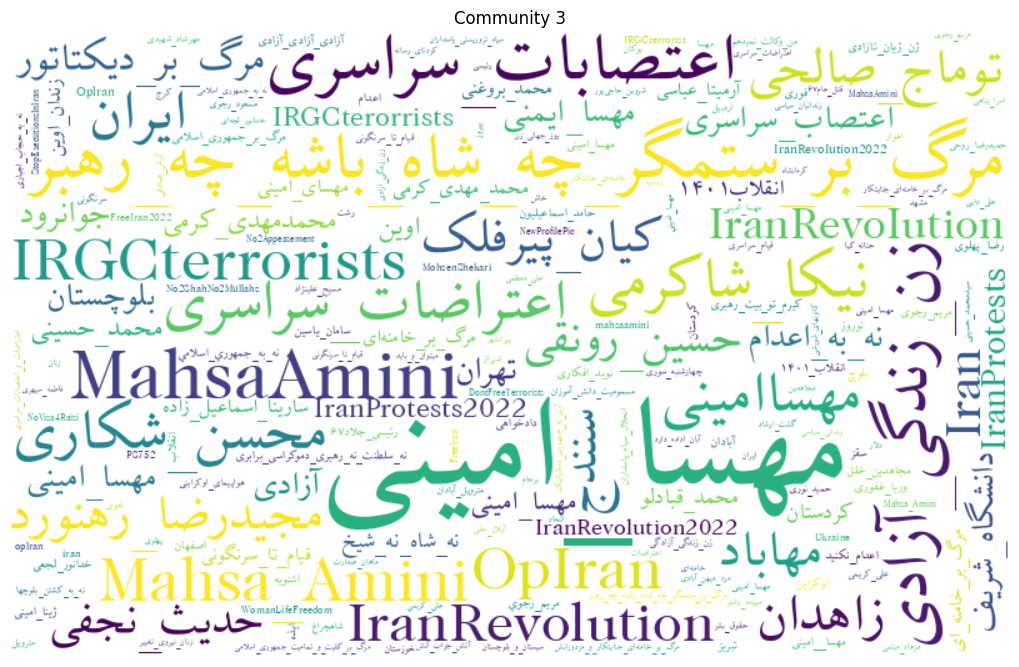

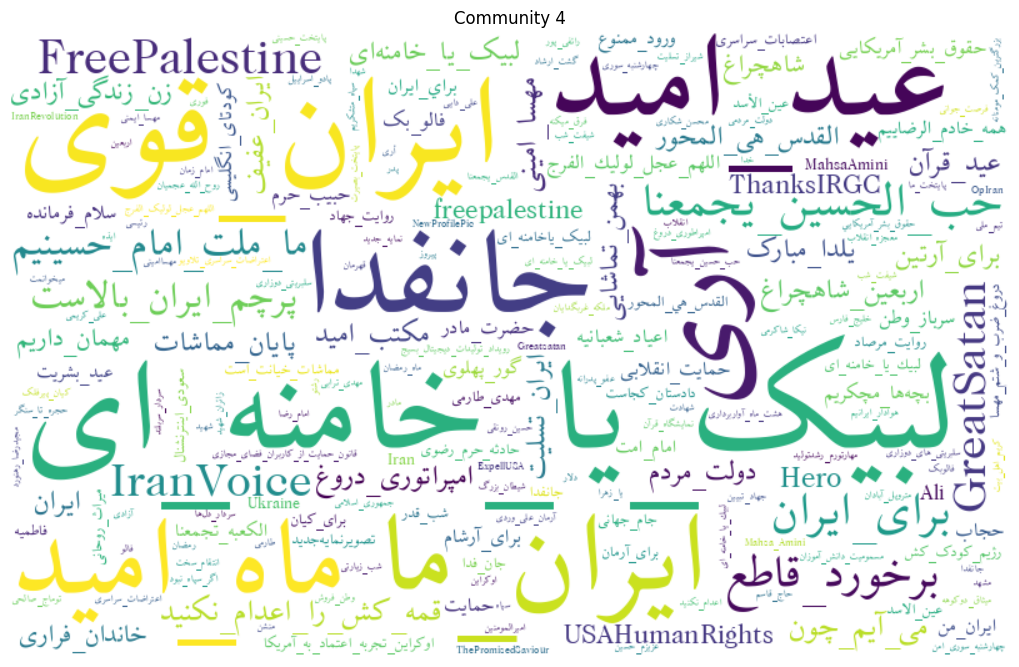

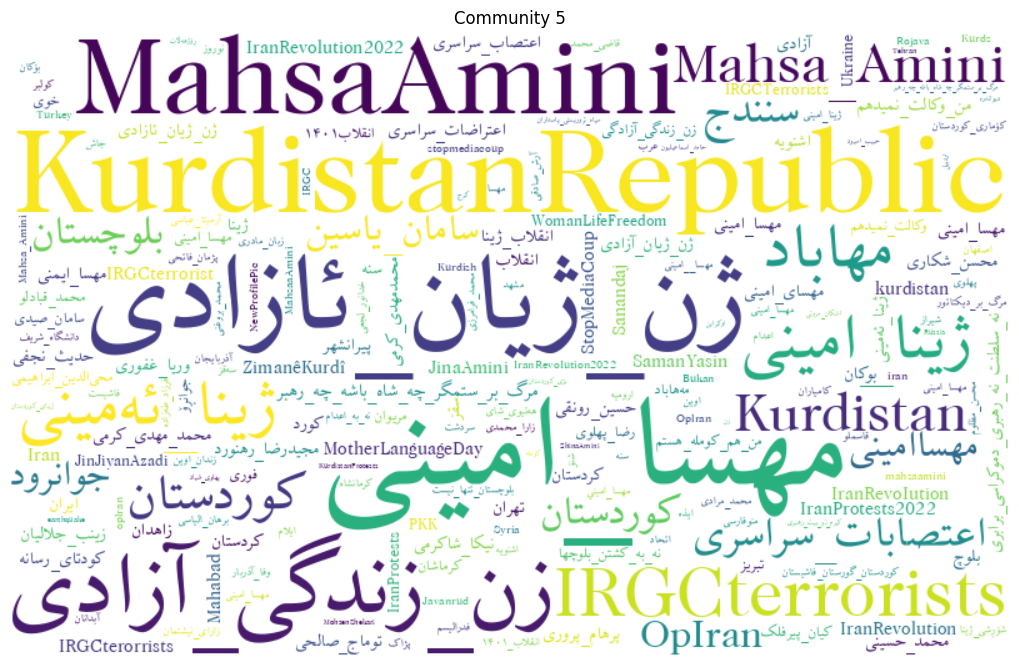

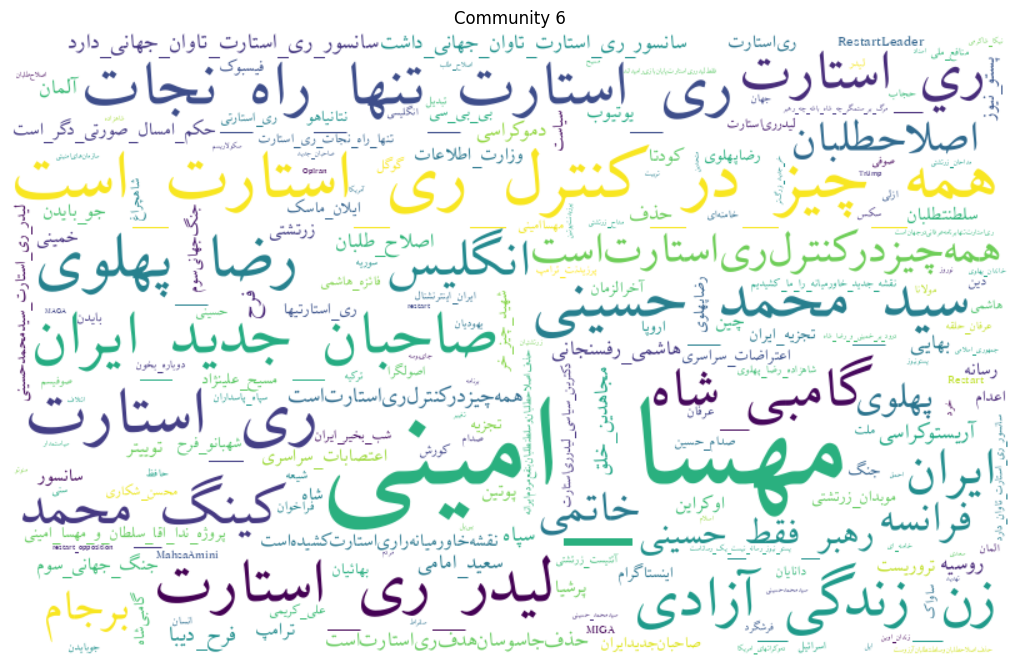

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams["axes.unicode_minus"] = False
from bidi.algorithm import get_display
import arabic_reshaper

#df = df_after

# assuming `df` is your DataFrame and it has a 'community' column
for community in sorted(df["community"].unique()):
    subset = df_unfiltered[df_unfiltered["community"] == community]
    # print(subset.columns)
    # #freq = subset.groupby("hashtag").count() 
    # # text = get_display(arabic_reshaper.reshape(text))
    # print(subset.head())
    # if subset.empty:
    #     print(f"No hashtags for community {community}. Skipping...")
    #     continue

    freq = subset.groupby("hashtag")["user_id"].size()
    freq = freq.sort_values(ascending=False)
    freq = freq[:200]
    # print(freq)
    wordcloud = WordCloud(
        font_path="/usr/share/fonts/TTF/XB-Zar-Regular.ttf",
        width=800,
        height=500,
        random_state=21,
        max_font_size=110,
        background_color="white",
    ).generate_from_frequencies(freq)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Community {community}")
    # plt.show()
    save_cloud_path = os.path.join( env["plots"], "analysis", "community0_finetune", f"community_{int(community)}.png")

    if not os.path.exists(os.path.dirname(save_cloud_path)):
        os.makedirs(os.path.dirname(save_cloud_path))

    # tight_layout() adjusts the subplot params so that the subplot(s) fits in to the figure area.
    plt.tight_layout()

    # remove the extra white space on the right side of the plot
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    
    plt.show()
    #plt.savefig(save_cloud_path)

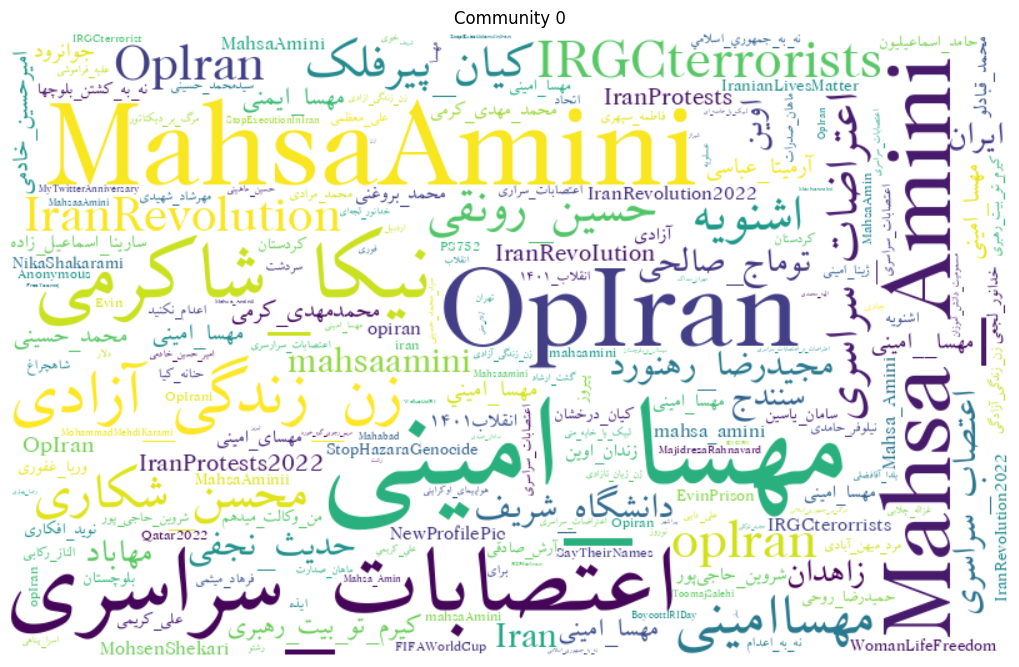

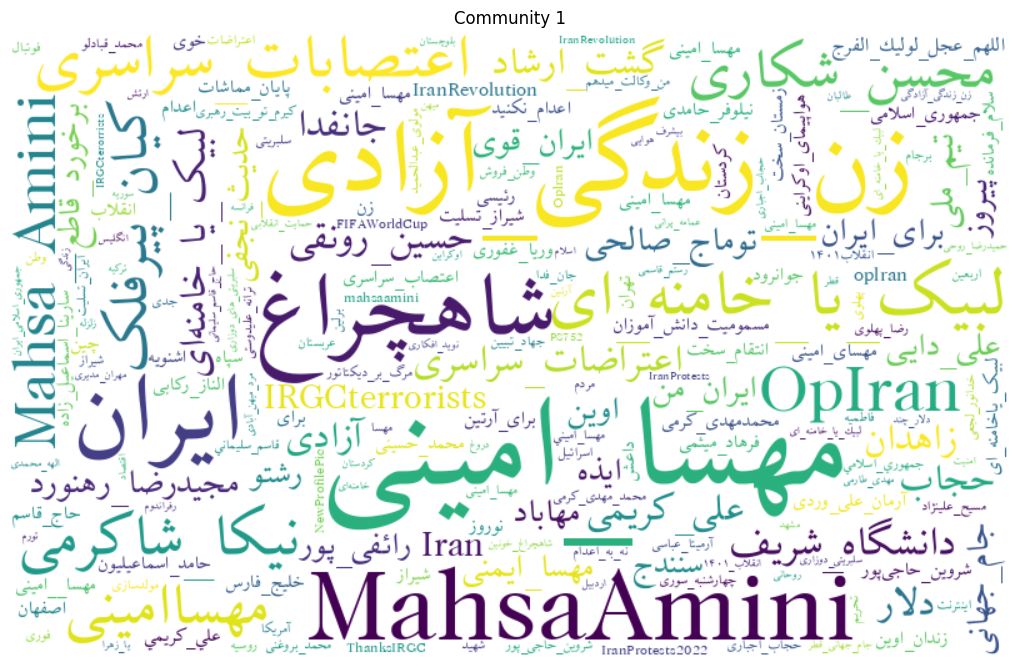

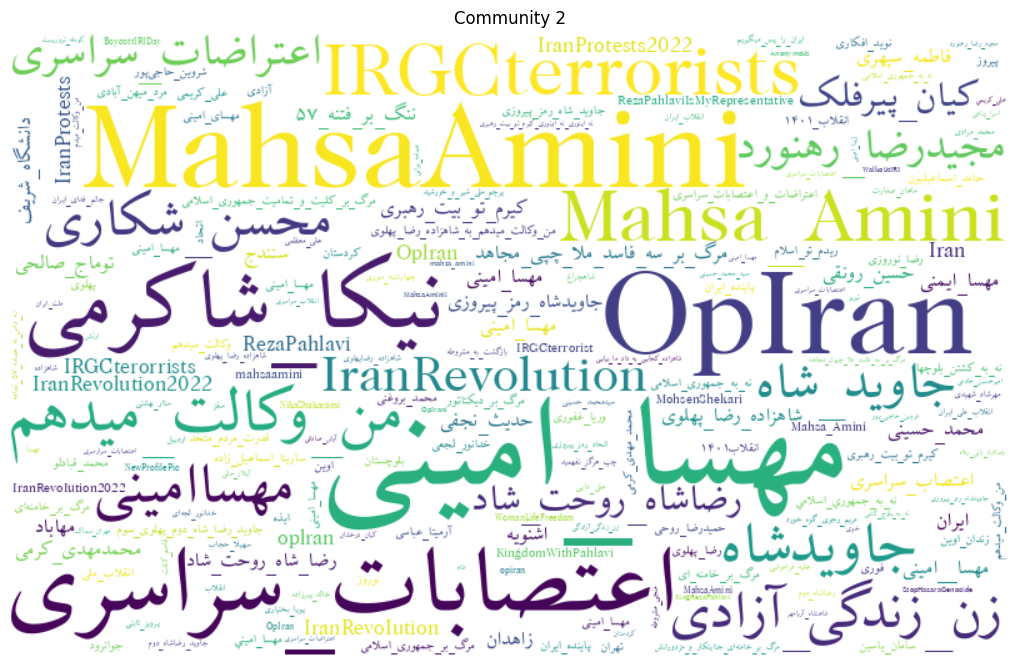

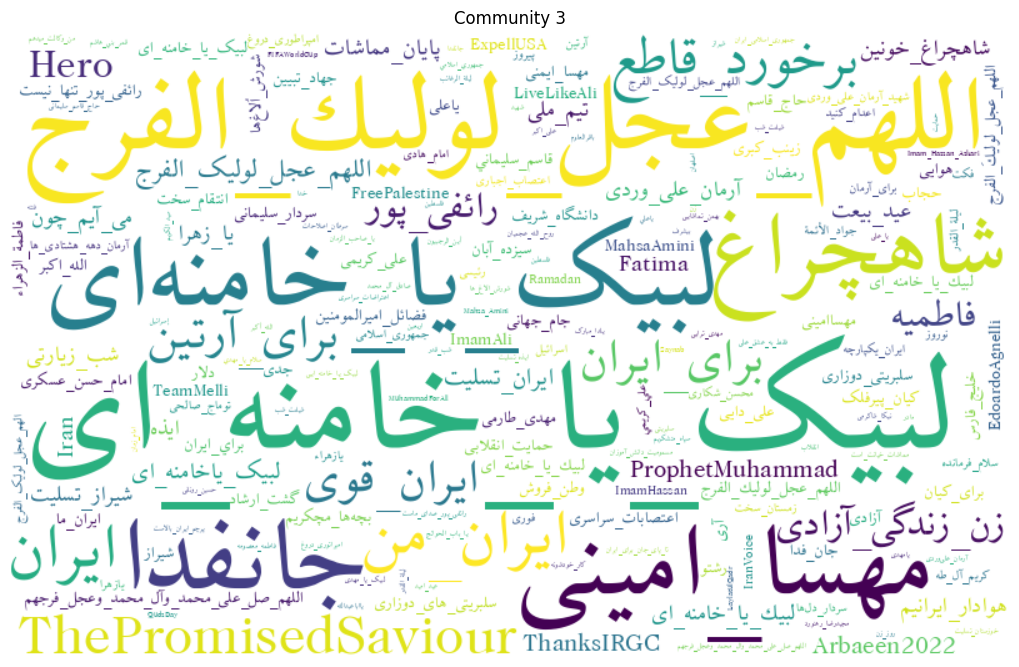

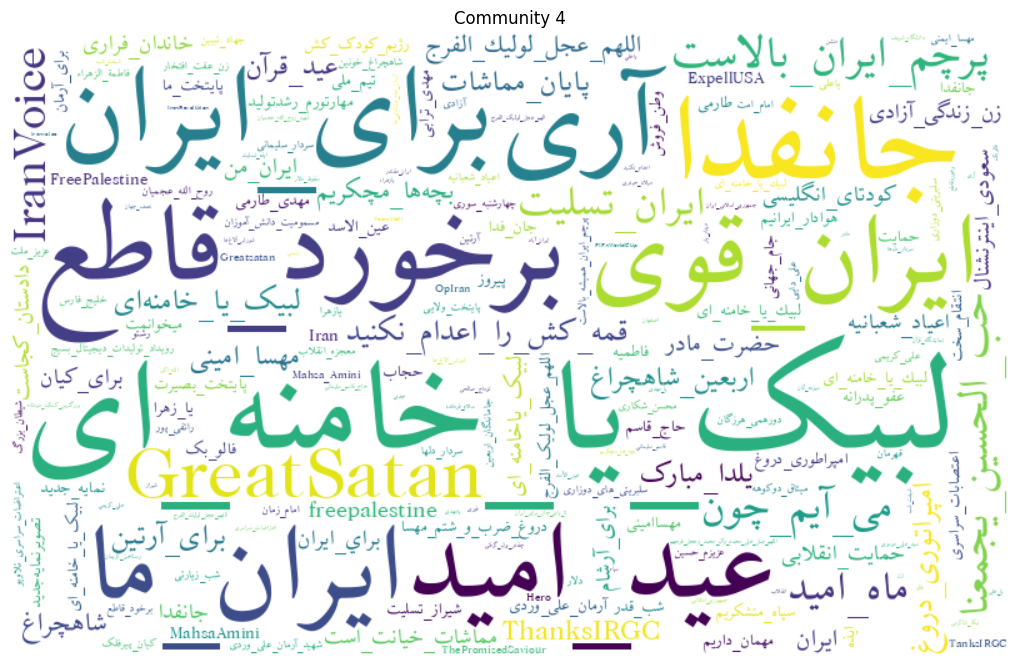

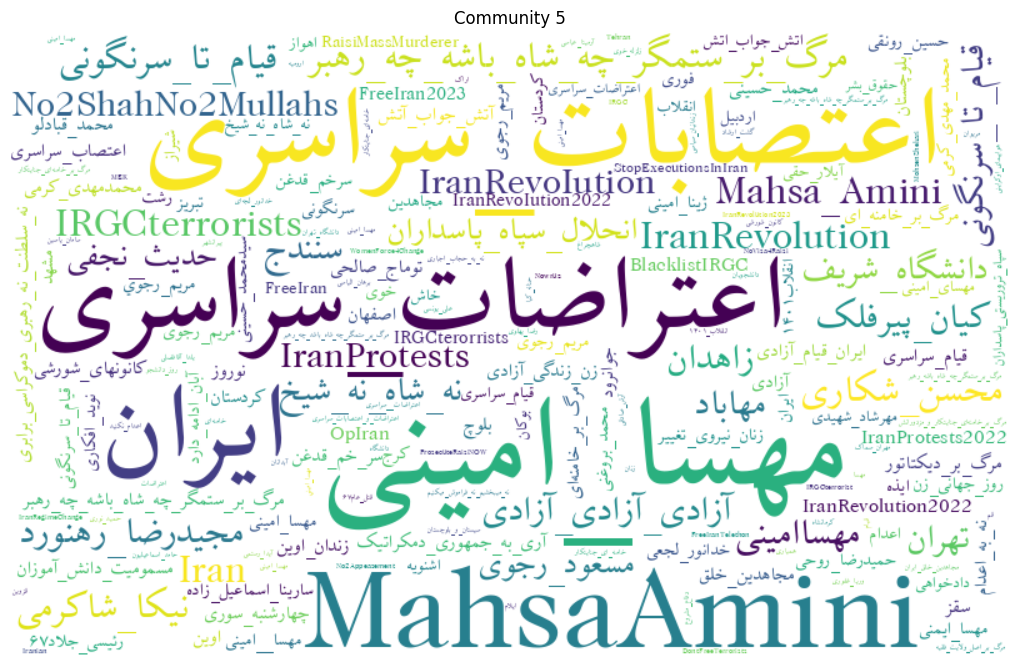

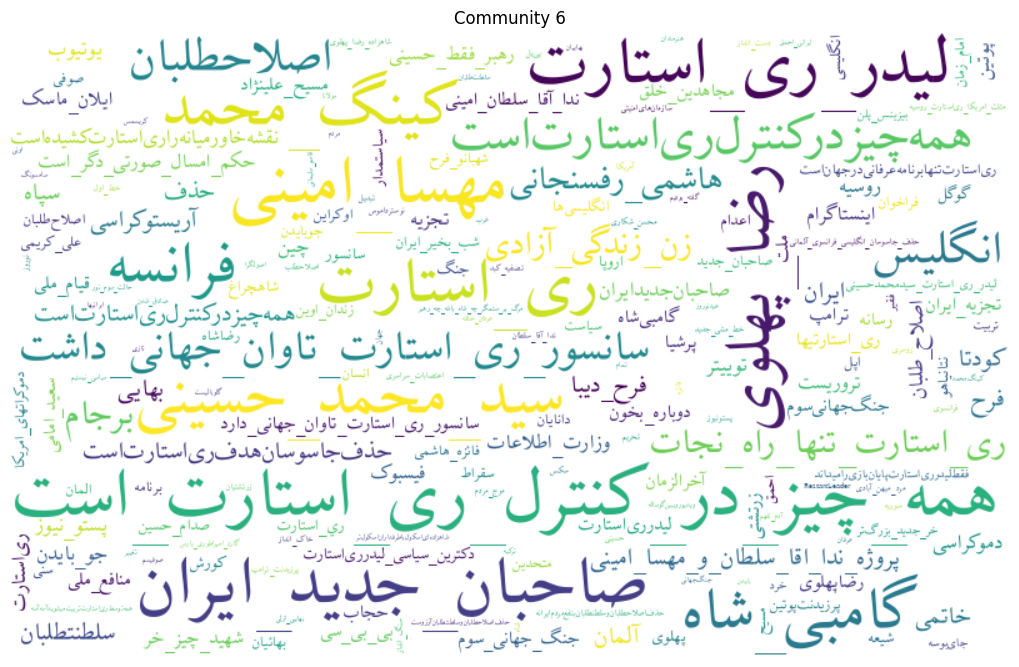

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams["axes.unicode_minus"] = False
from bidi.algorithm import get_display
import arabic_reshaper

#df = df_after

# assuming `df` is your DataFrame and it has a 'community' column
for community in sorted(df_after["community"].unique()):
    subset = df_after[df_after["community"] == community]
    # print(subset.columns)
    # #freq = subset.groupby("hashtag").count() 
    # # text = get_display(arabic_reshaper.reshape(text))
    # print(subset.head())
    # if subset.empty:
    #     print(f"No hashtags for community {community}. Skipping...")
    #     continue

    freq = subset.groupby("hashtag")['user_id'].count()
    # freq = subset.groupby("hashtag")["count"].size()
    freq = freq.sort_values(ascending=False)
    freq = freq[:200]
    # print(freq)
    wordcloud = WordCloud(
        font_path="/usr/share/fonts/TTF/XB-Zar-Regular.ttf",
        width=800,
        height=500,
        random_state=21,
        max_font_size=110,
        background_color="white",
    ).generate_from_frequencies(freq)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Community {community}")
    # plt.show()
    save_cloud_path = os.path.join( env["plots"], "analysis", "community0_finetune", f"community_{int(community)}_after.png")

    if not os.path.exists(os.path.dirname(save_cloud_path)):
        os.makedirs(os.path.dirname(save_cloud_path))

    # tight_layout() adjusts the subplot params so that the subplot(s) fits in to the figure area.
    plt.tight_layout()

    # remove the extra white space on the right side of the plot
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    
    plt.show()
    #plt.savefig(save_cloud_path)

In [75]:
graph_save_path = os.path.join(env['save'], 'graph', 'hashtag_communities')

# set name of hashtags to be the hashtag itself
g.vs[user_size:]["label"] = df["hashtag"].unique()

# set label of others to ''
g.vs[:user_size]["label"] =  df['userId'].unique()

if not os.path.exists(graph_save_path):
    os.makedirs(graph_save_path)

g.save(os.path.join(graph_save_path, 'hashtag_communities_bipart_0finetune.graphml'))


In [76]:
translation_cache = {}  # Translation cache to store previously translated hashtags

# save the translation cache as json
import json

path = os.path.join(env["save"], "translation_cache.json")

translation_cache = json.load(open(path, "r"))


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib
from bidi.algorithm import get_display
import arabic_reshaper
from googletrans import Translator
import requests
import time
from httpx import Timeout

translator = Translator(service_urls=['translate.google.com'], timeout=Timeout(5))

matplotlib.rcParams["axes.unicode_minus"] = False

# save top 20 hashtags for each community
top_twenty = {}

# assuming `df` is your DataFrame and it has a 'community' column
for community in sorted(df["community"].unique()):
    subset = df[df["community"] == community]

    freq = subset.groupby("hashtag")['user_id'].count()
    # freq = subset.groupby("hashtag")["count"].size()
    freq = freq.sort_values(ascending=False)
    top_freq = freq[:200]



    translator = Translator(service_urls=['translate.google.com'], timeout=Timeout(5))

    # Translate the top hashtags from Arabic to English
    translated_freq = {}
    for hashtag, count in top_freq.items():
        if hashtag in translation_cache:
            translated_hashtag = translation_cache[hashtag]
        else:
            translated_hashtag = None
            while translated_hashtag is None:
                try:
                    translation = translator.translate(hashtag.replace("_", " "), dest='en', src='auto')
                    if hasattr(translation, 'text') and translation.text is not None:
                        translated_hashtag = translation.text
                        translation_cache[hashtag] = translated_hashtag
                except:
                    time.sleep(5)  # Wait for 5 seconds before retrying
                    continue

        translated_freq[translated_hashtag] = count

    # save top twenty hashtags for each community and translation 
    top_twenty[community] = translated_freq

    wordcloud = WordCloud(
        font_path="/usr/share/fonts/TTF/XB-Zar-Regular.ttf",
        width=800,
        height=500,
        random_state=21,
        max_font_size=110,
        background_color="white",
    ).generate_from_frequencies(translated_freq)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Community {community}")

    save_cloud_path = os.path.join(env["plots"], "analysis", "community0_finetune", f"community_{int(community)}_en.png")

    if not os.path.exists(os.path.dirname(save_cloud_path)):
        os.makedirs(os.path.dirname(save_cloud_path))

    plt.tight_layout()
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    
    # plt.show()
    
    plt.savefig(save_cloud_path)

# save top 100 for as json



In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib
from bidi.algorithm import get_display
import arabic_reshaper
from googletrans import Translator
import requests
import time
from httpx import Timeout

translator = Translator(service_urls=['translate.google.com'], timeout=Timeout(5))

matplotlib.rcParams["axes.unicode_minus"] = False

# save top 20 hashtags for each community
top_twenty = {}

# assuming `df` is your DataFrame and it has a 'community' column
for community in sorted(df_after["community"].unique()):
    subset = df_after[df_after["community"] == community]


    freq = subset.groupby("hashtag")['user_id'].count()
    # freq = subset.groupby("hashtag")["count"].size()
    freq = freq.sort_values(ascending=False)
    top_freq = freq[:200]

    
    translator = Translator(service_urls=['translate.google.com'], timeout=Timeout(5))

    # Translate the top hashtags from Arabic to English
    translated_freq = {}
    for hashtag, count in top_freq.items():
        if hashtag in translation_cache:
            translated_hashtag = translation_cache[hashtag]
        else:
            translated_hashtag = None
            while translated_hashtag is None:
                try:
                    translation = translator.translate(hashtag.replace("_"," "), dest='en', src='auto')
                    if hasattr(translation, 'text') and translation.text is not None:
                        translated_hashtag = translation.text
                        translation_cache[hashtag] = translated_hashtag
                except:
                    time.sleep(5)  # Wait for 5 seconds before retrying
                    continue

        translated_freq[translated_hashtag] = count

    # save top twenty hashtags for each community and translation 
    top_twenty[community] = translated_freq

    wordcloud = WordCloud(
        font_path="/usr/share/fonts/TTF/XB-Zar-Regular.ttf",
        width=800,
        height=500,
        random_state=21,
        max_font_size=110,
        background_color="white",
    ).generate_from_frequencies(translated_freq)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Community {community}")

    save_cloud_path = os.path.join(env["plots"], "analysis", "community0_finetune", f"community_{int(community)}_en_after.png")

    if not os.path.exists(os.path.dirname(save_cloud_path)):
        os.makedirs(os.path.dirname(save_cloud_path))

    plt.tight_layout()
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    
    # plt.show()
    plt.savefig(save_cloud_path)

# save top 100 for as json

